1) Build a Siamese network for part matching with limited samples

Train pairs: (100000, 2, 32, 32, 3)
Test pairs: (20000, 2, 32, 32, 3)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_4        │ (None, 64)        │    322,688 │ input_layer_7[0]… │
│ (Functional)        │                   │            │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1)         │          0 │ functional_4[0][… │
│                     │                   │            │ functional_4[1][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 322,688 (1.23 MB)

 Trainable params: 322,688 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.2301 - val_loss: 0.1955
Epoch 2/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.1810 - val_loss: 0.1724
Epoch 3/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1562 - val_loss: 0.1614


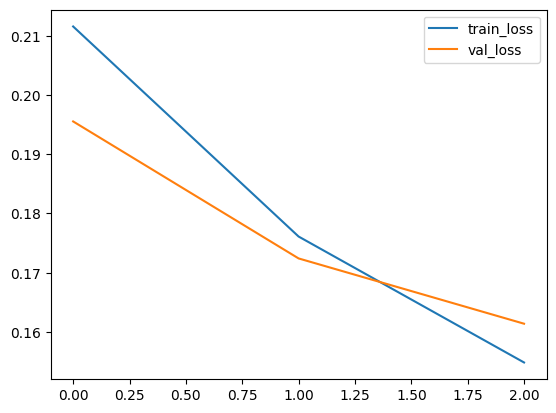

Test Accuracy (threshold=0.3): 0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step

Cosine Distance = 0.15797794
Prediction: SIMILAR


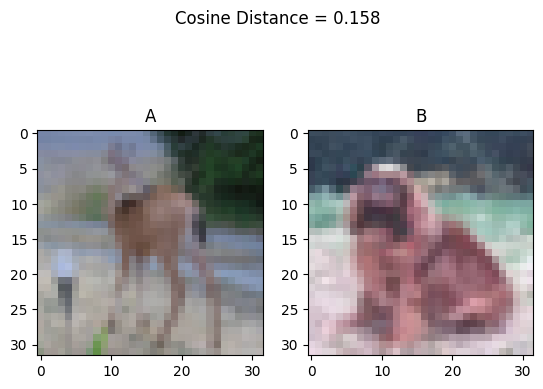

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

#  Contrastive Loss
def contrastive_loss(y_true, y_pred, margin=1.0):
    y_true = tf.cast(y_true, y_pred.dtype)
    positive_loss = y_true * tf.square(y_pred)
    negative_loss = (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(positive_loss + negative_loss)

#  Generate CIFAR-10 pairs
def make_pairs(images, labels):
    pairs = []
    pair_labels = []
    num_classes = len(np.unique(labels))
    class_idx = {i: np.where(labels == i)[0] for i in range(num_classes)}
    for idx in range(len(images)):
        x1 = images[idx]
        label = labels[idx]
        # Positive pair
        idx2 = np.random.choice(class_idx[label])
        x2 = images[idx2]
        pairs.append([x1, x2])
        pair_labels.append(1)
        # Negative pair
        neg_label = np.random.choice([l for l in range(num_classes) if l != label])
        idx3 = np.random.choice(class_idx[neg_label])
        x3 = images[idx3]
        pairs.append([x1, x3])
        pair_labels.append(0)
    return np.array(pairs), np.array(pair_labels)

#  Load CIFAR-10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

train_pairs, train_labels = make_pairs(x_train, y_train)
test_pairs, test_labels = make_pairs(x_test, y_test)

print("Train pairs:", train_pairs.shape)
print("Test pairs:", test_pairs.shape)

#  Build Base Network
def build_base_network():
    inp = keras.Input(shape=(32,32,3))
    x = layers.Conv2D(32,3,activation="relu")(inp)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64,3,activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128,activation="relu")(x)
    x = layers.Dense(64)(x)  # embedding
    return keras.Model(inp,x)

base_network = build_base_network()

#  Siamese Network with Cosine Similarity
def cosine_distance(vects):
    x, y = vects
    x = tf.math.l2_normalize(x, axis=1)
    y = tf.math.l2_normalize(y, axis=1)
    cos_sim = tf.reduce_sum(x * y, axis=1, keepdims=True)
    return 1 - cos_sim  # 0 = similar, 1 = opposite

input_a = keras.Input(shape=(32,32,3))
input_b = keras.Input(shape=(32,32,3))

feat_a = base_network(input_a)
feat_b = base_network(input_b)

distance = layers.Lambda(cosine_distance)([feat_a, feat_b])

siamese = keras.Model([input_a, input_b], distance)
siamese.compile(loss=contrastive_loss, optimizer="adam")
siamese.summary()

#  Train
history = siamese.fit(
    [train_pairs[:,0], train_pairs[:,1]],
    train_labels,
    validation_split=0.1,
    epochs=3,
    batch_size=64
)

plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

#  Evaluate Accuracy on Test Set
distances = siamese.predict([test_pairs[:,0], test_pairs[:,1]], verbose=0)

threshold = 0.3  # start value for cosine distance
preds = (distances < threshold).astype(int)
accuracy = np.mean(preds == test_labels)
print("Test Accuracy (threshold=0.3):", accuracy)

#  Test New Sample Similarity
i1, i2 = 100, 101
imgA, imgB = x_test[i1], x_test[i2]

d = siamese.predict([imgA[None], imgB[None]])[0][0]
print("\nCosine Distance =", d)

if d < threshold:
    print("Prediction: SIMILAR")
else:
    print("Prediction: DIFFERENT")

plt.subplot(1,2,1)
plt.imshow(imgA)
plt.title("A")
plt.subplot(1,2,2)
plt.imshow(imgB)
plt.title("B")
plt.suptitle(f"Cosine Distance = {d:.3f}")
plt.show()



2.Train an Autoencoder on defect-free samples to detect anomalies  

Train normal samples: (5000, 32, 32, 3)
Test samples (normal+anomaly): (10000, 32, 32, 3)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0420 - val_loss: 0.0129
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0112 - val_loss: 0.0083
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0078 - val_loss: 0.0067
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0065 - val_loss: 0.0062
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 9/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 10/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 11/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - val_loss: 0.0045
Epoch 12/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - val_l

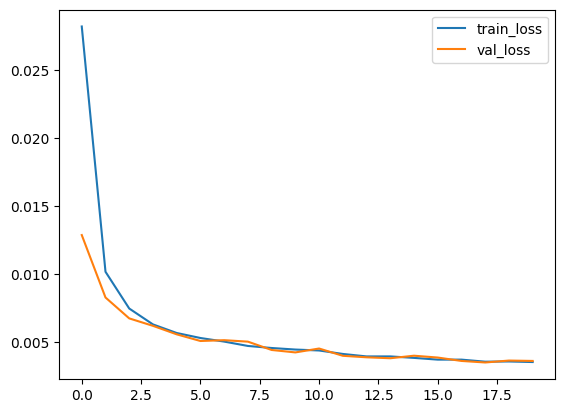

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


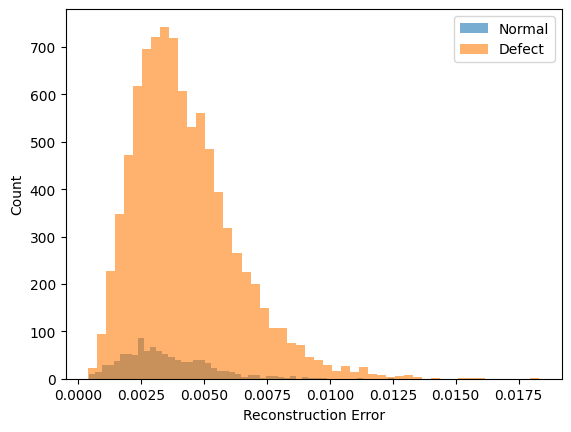

Anomaly detection threshold: 0.008770079
Classification Report:
               precision    recall  f1-score   support

         0.0       0.10      0.99      0.18      1000
         1.0       0.96      0.03      0.06      9000

    accuracy                           0.13     10000
   macro avg       0.53      0.51      0.12     10000
weighted avg       0.87      0.13      0.07     10000

ROC-AUC: 0.6162793888888889


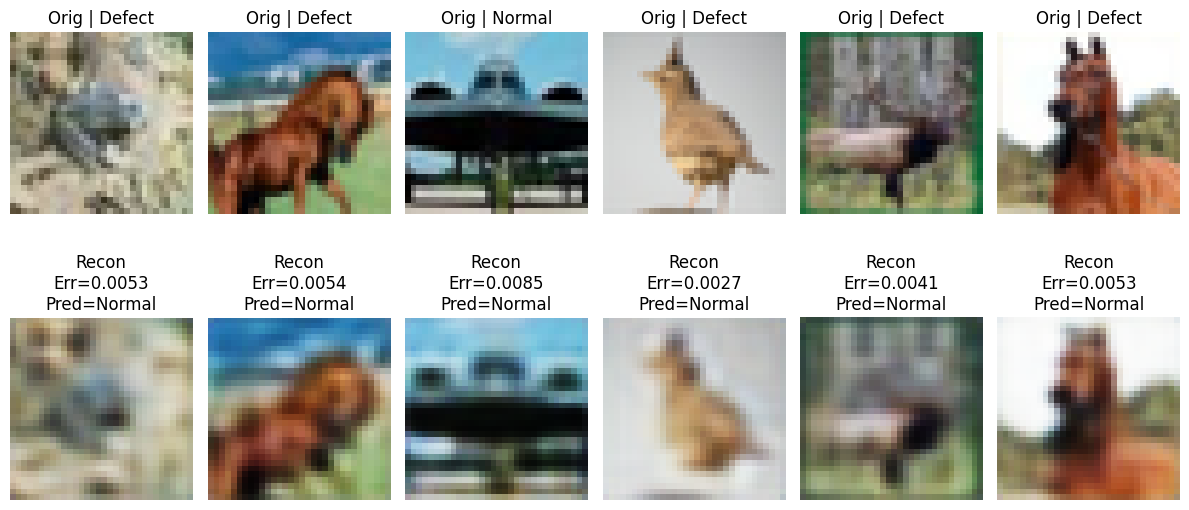

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# 1. Load Data (simulate defect-free)
# Using CIFAR-10 "airplane" as defect-free normal class
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
y_train = y_train.flatten()
y_test = y_test.flatten()

# Keep only "airplane" class as defect-free normal samples
normal_class = 0
x_train_normal = x_train[y_train == normal_class]

# For testing, mix normal + some anomalies
x_test_normal = x_test[y_test.flatten() == normal_class]
x_test_anomaly = x_test[y_test.flatten() != normal_class]
x_test_combined = np.concatenate([x_test_normal, x_test_anomaly])
y_test_combined = np.concatenate([np.zeros(len(x_test_normal)), np.ones(len(x_test_anomaly))])  # 0=normal, 1=defect

print("Train normal samples:", x_train_normal.shape)
print("Test samples (normal+anomaly):", x_test_combined.shape)

# 2. Build Autoencoder
input_shape = x_train_normal.shape[1:]
inputs = keras.Input(shape=input_shape)

# Encoder
x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
x = layers.MaxPooling2D(2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
encoded = layers.MaxPooling2D(2, padding="same")(x)

# Decoder
x = layers.Conv2D(64, 3, activation="relu", padding="same")(encoded)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
x = layers.UpSampling2D(2)(x)
decoded = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(x)

autoencoder = keras.Model(inputs, decoded)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

# 3. Train Autoencoder
history = autoencoder.fit(
    x_train_normal, x_train_normal,
    epochs=20,
    batch_size=64,
    validation_split=0.1
)

plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

# 4. Detect Anomalies
# Compute reconstruction errors
reconstructions = autoencoder.predict(x_test_combined)
errors = np.mean((x_test_combined - reconstructions) ** 2, axis=(1,2,3))

# Visualize histogram
plt.hist(errors[y_test_combined==0], bins=50, alpha=0.6, label="Normal")
plt.hist(errors[y_test_combined==1], bins=50, alpha=0.6, label="Defect")
plt.legend()
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.show()

# Set threshold (example: mean + 3*std of normal errors)
threshold = errors[y_test_combined==0].mean() + 3*errors[y_test_combined==0].std()
print("Anomaly detection threshold:", threshold)

# Predict anomalies
y_pred = (errors > threshold).astype(int)

# Accuracy / detection performance
from sklearn.metrics import classification_report, roc_auc_score
print("Classification Report:\n", classification_report(y_test_combined, y_pred))
print("ROC-AUC:", roc_auc_score(y_test_combined, errors))

# =============================
# 5. Show Test Image + Reconstruction + Error
# =============================
num_samples_to_show = 6
indices = np.random.choice(len(x_test_combined), num_samples_to_show, replace=False)

plt.figure(figsize=(12, 6))

for i, idx in enumerate(indices):
    orig = x_test_combined[idx]
    recon = reconstructions[idx]
    err = errors[idx]
    label = y_test_combined[idx]
    pred = y_pred[idx]

    plt.subplot(2, num_samples_to_show, i + 1)
    plt.imshow(orig)
    plt.title(f"Orig | {'Normal' if label==0 else 'Defect'}")
    plt.axis("off")

    plt.subplot(2, num_samples_to_show, i + 1 + num_samples_to_show)
    plt.imshow(recon)
    plt.title(f"Recon\nErr={err:.4f}\nPred={'Defect' if pred==1 else 'Normal'}")
    plt.axis("off")

plt.tight_layout()
plt.show()

